Libraries

In [181]:
import pickle
import numpy as np
import pandas as pd
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings

from numpy.linalg import solve, norm
from scipy.cluster.hierarchy import fcluster

warnings.filterwarnings("ignore")

path = os.getcwd()
print(path)
os.chdir(path)



/Users/ruimaciel/Desktop/Barcelona/ML_Finance/2nd_homework_ml


### Aux Functions

In [182]:
def log_return(df):
    return np.log(df).diff().drop(index=df.index[0], axis=0, inplace=False)

def na_fill(df):
    # Simulates `na.fill(as.xts(rowAvgs(df),order.by=index(df)),"extend")`
    return df.interpolate(method="linear").fillna(method="bfill")

def create_index(df):
    # the linear method already does ffill for the tail values
    return na_fill(df.mean(axis=1, skipna=False))

def cov2cor(df):
    ind = df.index
    col = df.columns
    sigma = np.sqrt(np.diag(df))
    return df.div(pd.DataFrame(np.outer(sigma, sigma), index=ind, columns=col))

def clusterplot(cov, ncluster=6):
    sns.set(style='white')
    sns_plot = sns.clustermap(cov2cor(cov), cmap='vlag_r', robust=True, method="complete", vmin=-1, vmax=1)
    plt.setp(sns_plot.ax_heatmap.yaxis.get_majorticklabels(), fontsize=14, color='red')  # Corrected here
    plt.setp(sns_plot.ax_heatmap.xaxis.get_majorticklabels(), fontsize=14, color='red')  # Corrected here
    plt.title("Correlation")

    Z = sns_plot.dendrogram_row.linkage
    clusters = list(fcluster(Z, ncluster, criterion='maxclust'))
    assign_cluster = dict((k, clusters[k]) for k in range(len(cov.columns)))
    assigned_idx = [assign_cluster[idx] for idx in sns_plot.dendrogram_row.reordered_ind]
    i = 0
    while i < len(assigned_idx):
        cluster = assigned_idx[i]
        counter = 0
        while i < len(assigned_idx) and assigned_idx[i] == cluster:
            counter += 1
            i += 1
        sns_plot.ax_heatmap.add_patch(plt.Rectangle(
            xy=(i-counter, i-counter),
            width=counter,
            height=counter,
            fill=None, color='black', lw=1.5
        ))
    plt.show()


# Load stocks price and select our time frame and stocks


In [183]:
import pandas as pd

begin_date = "2015-01-01"
end_date = "2016-12-31"
columns_to_drop= ['JPM', 'KO', 'MCD', 'MSFT', 'PFE', 'XOM']

# Load stock data
stocks = pd.read_csv('adjusted.csv')
stocks['Date'] = pd.to_datetime(stocks['Date'])
stocks = stocks[(stocks['Date'] >= begin_date) & (stocks['Date'] <= end_date)]
stocks = stocks.drop(columns=columns_to_drop)

# Load PNlog data
PNlog = pd.read_csv("PNlog.csv")
PNlog['Date'] = pd.to_datetime(PNlog['Date'])
PNlog = PNlog[(PNlog['Date'] >= begin_date) & (PNlog['Date'] <= end_date)]
PNlog = PNlog.drop(columns=columns_to_drop)

In [184]:
stocks

,Date,AAPL,ABBV,AMZN,DB,DIS,FB,GOOG,HAL,HSBC
1,2015-01-02,99.945885,51.718132,308.519989,28.562273,87.376266,78.449997,523.373108,34.983353,33.575310
2,2015-01-05,97.130241,50.744839,302.190002,27.015579,86.099403,77.190002,512.463013,34.292366,32.804939
3,2015-01-06,97.139420,50.493664,295.290009,26.584383,85.642708,76.150002,500.585632,33.955738,32.327015
4,2015-01-07,98.501518,52.534447,298.420013,26.865599,86.518814,76.150002,499.727997,34.868195,32.576675
5,2015-01-08,102.286186,53.083889,300.459991,26.921841,87.413536,78.180000,501.303680,35.621181,32.683674
...,...,...,...,...,...,...,...,...,...,...
500,2016-12-23,110.743988,52.492733,760.590027,17.915533,100.693771,117.269997,789.909973,50.292454,32.497345
501,2016-12-27,111.447319,52.627453,771.400024,17.665504,100.712914,118.010002,791.549988,50.356640,32.497345
502,2016-12-28,110.972122,52.433788,772.130005,17.232763,99.879791,116.919998,785.049988,49.797234,32.415836
503,2016-12-29,110.943588,52.821125,765.150024,17.136597,100.128761,116.349998,782.789978,49.558796,32.415836


In [185]:
PNlog

,Date,AAPL,ABBV,AMZN,DB,DIS,FB,GOOG,HAL,HSBC
0,2015-01-02,0.010336,-0.015882,-0.020067,0.004023,0.008930,-0.010094,0.007672,0.001855,-0.037944
1,2015-01-05,0.014229,0.000000,0.013374,0.008442,0.010258,0.011148,-0.002559,-0.012387,-0.023388
2,2015-01-06,0.017950,0.010092,0.019457,-0.005736,-0.016278,0.007027,0.017585,0.019216,-0.035777
3,2015-01-07,0.000000,0.010801,-0.010497,0.010894,-0.002005,0.010447,-0.004112,0.003567,-0.021697
4,2015-01-08,0.005537,0.007774,0.010360,-0.003153,0.041047,-0.003588,0.015942,0.001991,-0.009976
...,...,...,...,...,...,...,...,...,...,...
499,2016-12-23,-0.046832,-0.015995,0.001139,0.000000,0.000000,0.000000,0.019631,NaN,-0.005752
500,2016-12-27,-0.001563,NaN,0.007011,0.000000,0.007284,-0.035964,0.009811,-0.028647,NaN
501,2016-12-28,0.001133,NaN,0.000000,-0.003170,0.018131,-0.035765,0.015583,-0.040662,-0.003455
502,2016-12-29,-0.019729,NaN,-0.008228,0.004028,-0.044793,-0.053111,0.007714,0.000000,-0.011610


# Preprocess the data

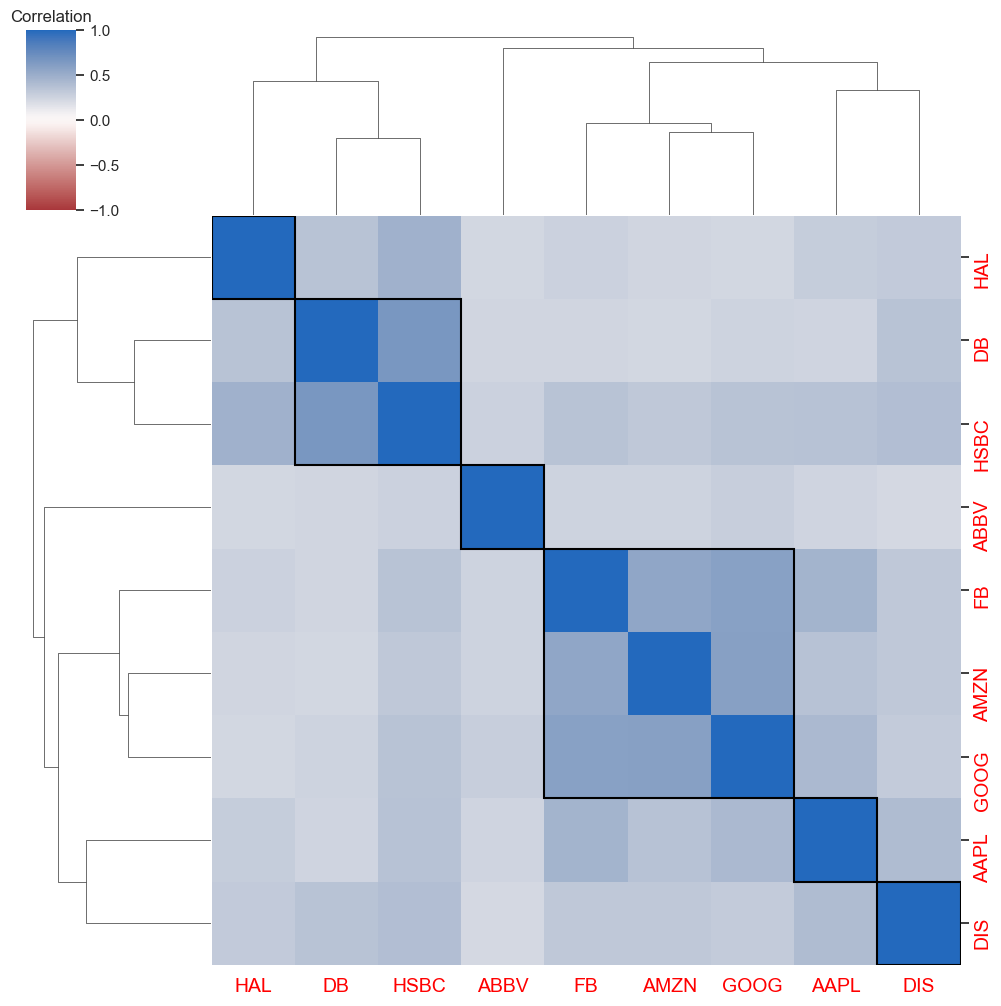

In [186]:
# Processing the data
stocks.set_index('Date', inplace=True)
PNlog.set_index('Date', inplace=True)

# Calculate log returns for stocks and PNlog
X = log_return(stocks)

# Create market index from PNlog
PNlog_indexed = create_index(PNlog)

# Check alignment and apply na_fill if necessary
X = na_fill(X)

# Example correlation and cluster plotting (optional, on demand)
cov_matrix = X.cov()
clusterplot(cov_matrix)

In [187]:
#Check missing data
PNlog_indexed.isnull().sum()

0

In [188]:
PNlog_indexed

Date
2015-01-02   -0.005686
2015-01-05    0.002124
2015-01-06    0.003726
2015-01-07   -0.000289
2015-01-08    0.007326
                ...   
2016-12-23   -0.014910
2016-12-27   -0.014910
2016-12-28   -0.014910
2016-12-29   -0.014910
2016-12-30   -0.014910
Length: 504, dtype: float64

In [189]:
# Sentiment Index - already aligned and filled
SentIndx = PNlog_indexed

# Create DataFrame for linear regression with a constant term
F = SentIndx.copy().to_frame()
F.insert(0, 'ones', 1)  # Adding a constant term for regression

# Calculate number of observations and number of stocks
T, N = X.shape  # T = number of rows (time periods), N = number of columns (stocks)

# Split data into training and test sets
T_trn = round(0.5*T)
X_trn = X.iloc[0:T_trn, ]
X_tst = X.iloc[T_trn:T, ]
SentIndx_trn = SentIndx.iloc[0:T_trn,]
SentIndx_tst = SentIndx.iloc[T_trn:T,]

In [190]:
print(X_trn.isna().sum())


AAPL    0
ABBV    0
AMZN    0
DB      0
DIS     0
FB      0
GOOG    0
HAL     0
HSBC    0
dtype: int64


In [191]:
print(SentIndx_trn.isna().sum())
print(SentIndx_tst.isna().sum())


0
0


# Regression to find alpha and beta parameters using training data

In [192]:
Gamma = pd.DataFrame(solve(F.iloc[0:T_trn].T @ F.iloc[0:T_trn], F.iloc[0:T_trn].T.to_numpy() @ X_trn.to_numpy()).T, columns=["alpha", "beta"])
alpha = Gamma["alpha"]
beta = Gamma["beta"]

# Calculate residuals to estimate specific risks
E = pd.DataFrame((X_trn.T - (Gamma.to_numpy() @ F.iloc[0:T_trn].to_numpy().T)).T, index=X_trn.index)
Psi_Sent = (E.T @ E) / (T_trn - 2)  # Estimating specific risks

# Calculate the perturbation matrix using the sentiment index
Sigma_SentInx = SentIndx_trn.var() * np.outer(beta, beta) + np.diag(np.diag(Psi_Sent))
Sigma_SentInx

array([[ 2.84714780e-04, -5.94364541e-08,  3.40698361e-07,
         5.24042541e-07,  2.35127444e-07,  4.35509062e-07,
         1.20897526e-07, -1.90936308e-07, -3.43596601e-07],
       [-5.94364541e-08,  4.09368424e-04, -5.98015430e-08,
        -9.19832794e-08, -4.12710643e-08, -7.64433200e-08,
        -2.12207027e-08,  3.35143550e-08,  6.03102604e-08],
       [ 3.40698361e-07, -5.98015430e-08,  4.40505291e-04,
         5.27261477e-07,  2.36571717e-07,  4.38184180e-07,
         1.21640141e-07, -1.92109136e-07, -3.45707146e-07],
       [ 5.24042541e-07, -9.19832794e-08,  5.27261477e-07,
         4.03229736e-04,  3.63880951e-07,  6.73989596e-07,
         1.87099838e-07, -2.95491177e-07, -5.31746764e-07],
       [ 2.35127444e-07, -4.12710643e-08,  2.36571717e-07,
         3.63880951e-07,  2.07285313e-04,  3.02405700e-07,
         8.39479687e-08, -1.32581002e-07, -2.38584176e-07],
       [ 4.35509062e-07, -7.64433200e-08,  4.38184180e-07,
         6.73989596e-07,  3.02405700e-07,  2.650415

# Trying different Kappas and noise

In [193]:
# Define kappa values and noise levels
kappa_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]  # Adjust kappa to see effects on the portfolio weights
noise_levels = [0.01, 0.05, 0.1, 0.15, 0.2]  # Standard deviations for Gaussian noise


In [194]:
# Apply noise and recalcute the covariance matrix

def apply_noise_and_recalculate(SentIndx, X, beta, Psi_Sent, noise_level):
    noisy_SentIndx = SentIndx + np.random.normal(0, noise_level, SentIndx.shape)
    # Recalculate variance with noise
    var_noisy = noisy_SentIndx.var()
    Sigma_noisy_SentInx = var_noisy * np.outer(beta, beta) + np.diag(np.diag(Psi_Sent))
    return Sigma_noisy_SentInx



In [195]:
import cvxpy as cp

results = []

for kappa in kappa_values:
    for noise_level in noise_levels:
        Sigma_noisy_SentInx = apply_noise_and_recalculate(SentIndx_trn, X_trn, beta, Psi_Sent, noise_level)
        Sigma_noisy_SentInx = symmetrize(Sigma_noisy_SentInx)  # Ensure the matrix is symmetric

        # Define optimization variables
        w = cp.Variable(N)

        # Objective function components
        expected_return = w.T @ alpha
        robustness_term = kappa * cp.quad_form(w, Sigma_noisy_SentInx)
        regularization_term = 0.01 * cp.norm(w, 1)  # L1 regularization to promote sparsity

        # Maximize expected returns adjusted for robustness and regularization
        objective = cp.Maximize(expected_return - robustness_term - regularization_term)
        constraints = [cp.sum(w) == 1, w >= 0]  # Sum of weights must be 1, no short selling
        
        # Problem setup and solve
        prob = cp.Problem(objective, constraints)
        prob.solve()
        
        # Store results
        results.append({
            'kappa': kappa,
            'noise_level': noise_level,
            'portfolio_weights': w.value
        })

# Print results
for result in results:
    print(f"Kappa: {result['kappa']}, Noise: {result['noise_level']}, Weights: {result['portfolio_weights']}")

Kappa: 0.1, Noise: 0.01, Weights: [2.23074049e-05 2.23726291e-05 9.99821324e-01 2.23647551e-05
 2.22696393e-05 2.22967478e-05 2.23324162e-05 2.24095515e-05
 2.22567578e-05]
Kappa: 0.1, Noise: 0.05, Weights: [2.14200863e-05 2.15392567e-05 9.99828195e-01 2.14476926e-05
 2.13992624e-05 2.13959964e-05 2.14751981e-05 2.15931163e-05
 2.14707455e-05]
Kappa: 0.1, Noise: 0.1, Weights: [1.85718832e-05 1.88331468e-05 9.99850380e-01 1.85192201e-05
 1.85968940e-05 1.85122895e-05 1.87065217e-05 1.89312618e-05
 1.88930280e-05]
Kappa: 0.1, Noise: 0.15, Weights: [1.57861696e-05 1.61424171e-05 9.99872262e-01 1.56765195e-05
 1.58439119e-05 1.57026341e-05 1.59743863e-05 1.62695023e-05
 1.62944118e-05]
Kappa: 0.1, Noise: 0.2, Weights: [1.04267459e-05 1.08489208e-05 9.99914850e-01 1.02645445e-05
 1.05153588e-05 1.03257888e-05 1.06537676e-05 1.09937525e-05
 1.10892665e-05]
Kappa: 0.2, Noise: 0.01, Weights: [2.34860966e-06 2.25716148e-06 9.99981417e-01 2.26958758e-06
 2.40047814e-06 2.36358775e-06 2.31343262e

# Visualizations of results

In [196]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [197]:
# Putting results into a DataFrame
results_df = pd.DataFrame(results)

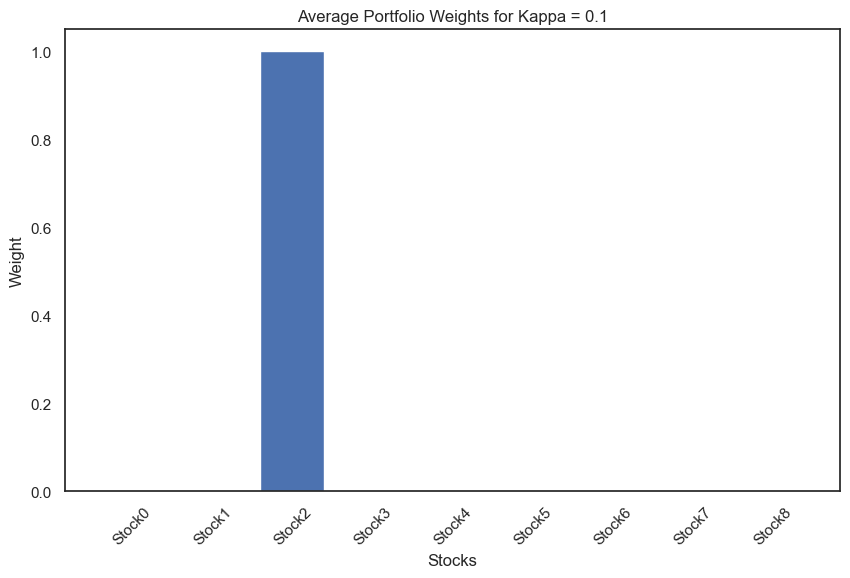

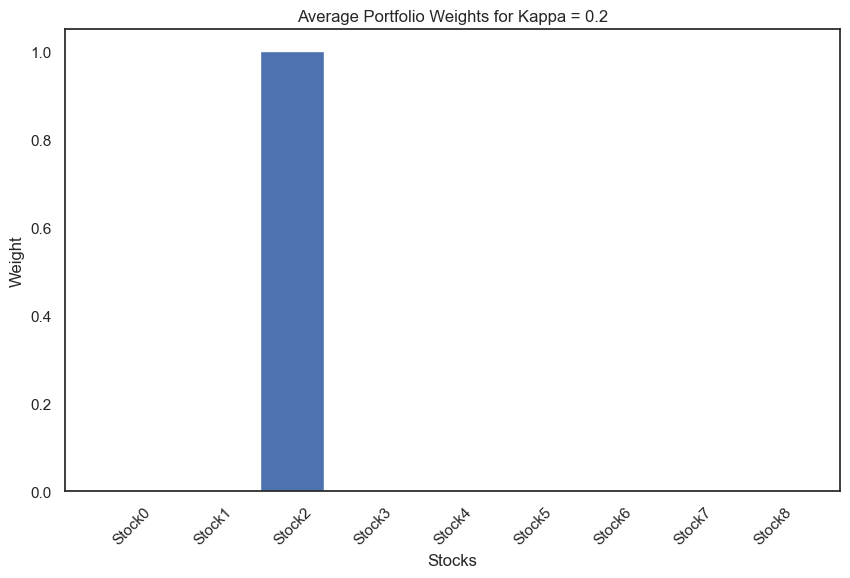

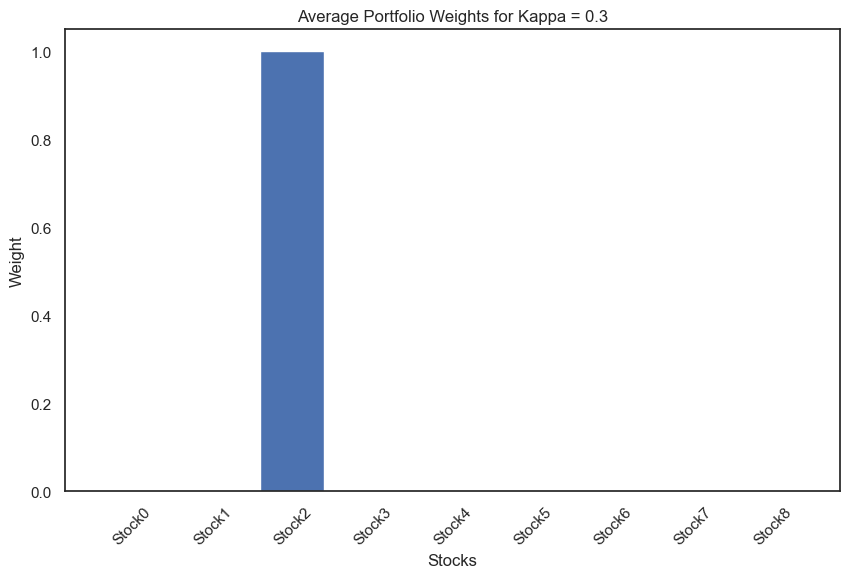

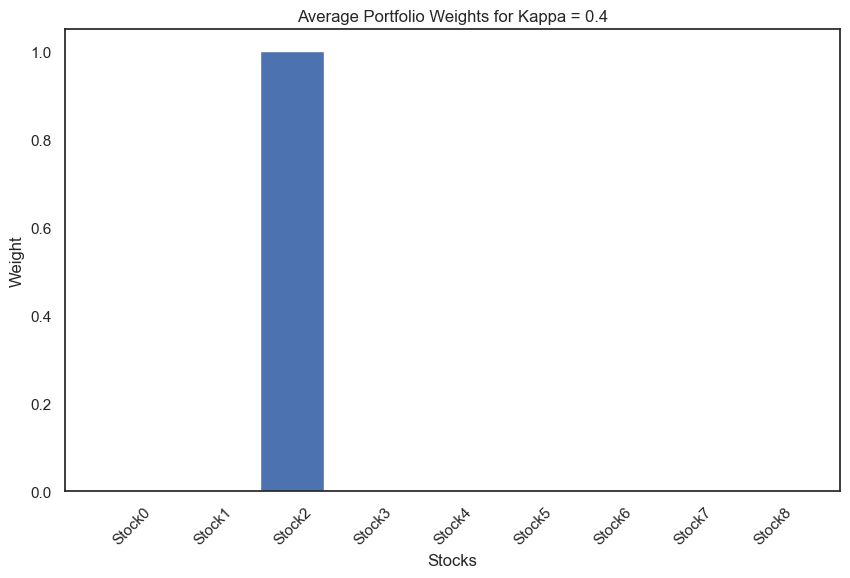

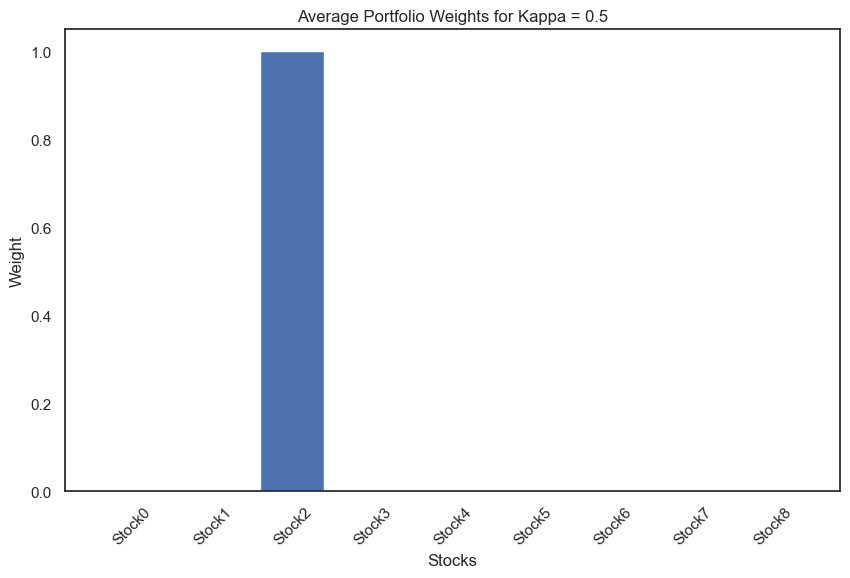

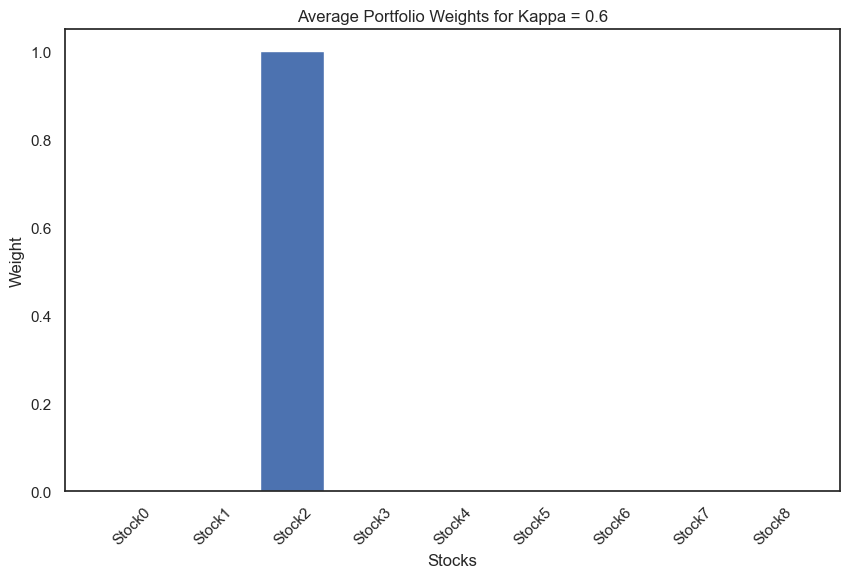

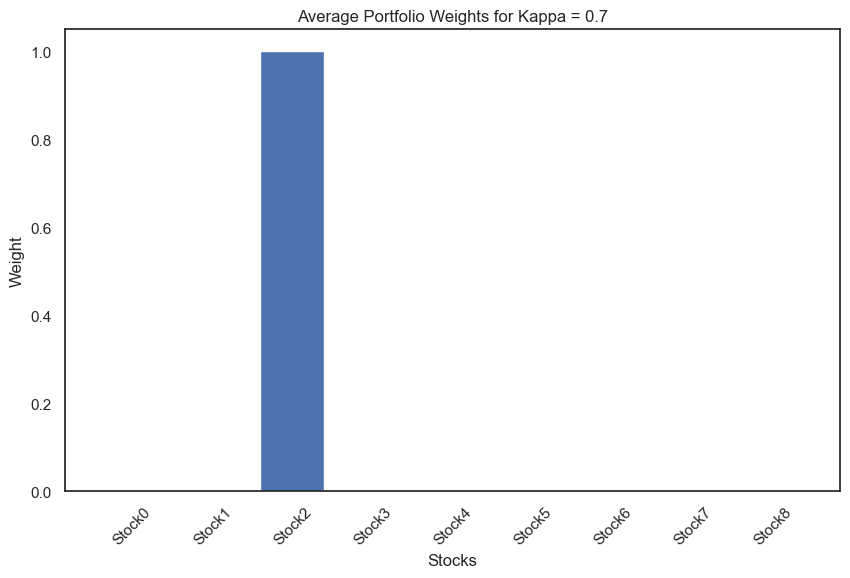

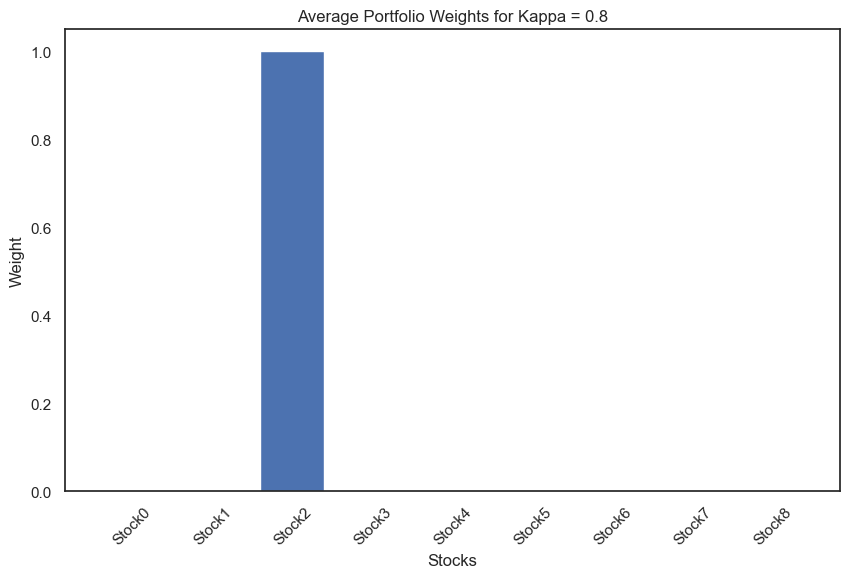

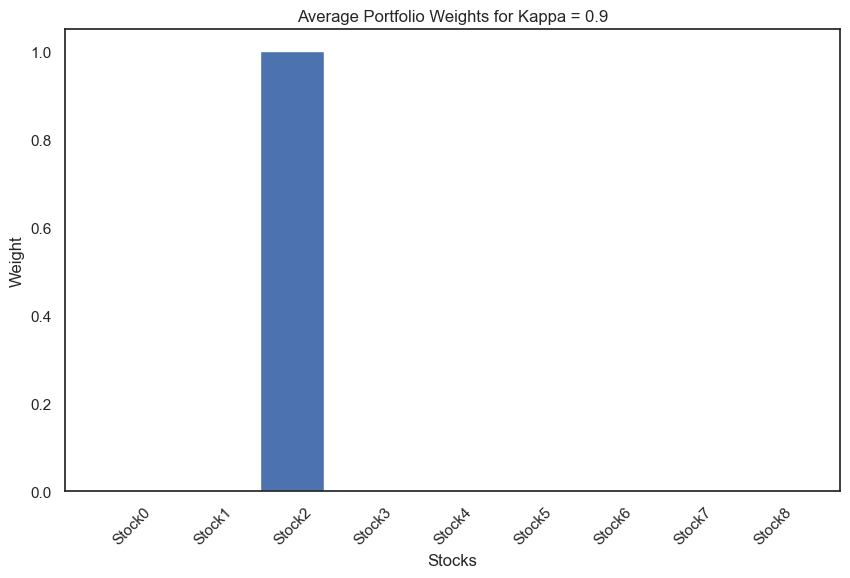

In [198]:
# Function to extract average weights for each kappa
def get_avg_weights_for_kappa(kappa, results_df, N):
    subset = results_df[results_df['kappa'] == kappa]
    weights_matrix = np.array(subset['portfolio_weights'].tolist())
    avg_weights = weights_matrix.mean(axis=0)
    return avg_weights

# Plot the average portfolio weights for each kappa
for kappa in kappa_values:
    avg_weights = get_avg_weights_for_kappa(kappa, results_df, N)
    plt.figure(figsize=(10, 6))
    plt.bar(range(N), avg_weights)
    plt.title(f'Average Portfolio Weights for Kappa = {kappa}')
    plt.ylabel('Weight')
    plt.xlabel('Stocks')
    plt.xticks(range(N), [f'Stock{i}' for i in range(N)], rotation=45)
    plt.show()


In [199]:
# Assess stability

# Calculate standard deviations of weights across all simulations
weights_df = pd.DataFrame(list(results_df['portfolio_weights']), columns=['Stock'+str(i) for i in range(N)])
stability = weights_df.std()
print("Stability of stock weights (lower is more stable):")
print(stability)


Stability of stock weights (lower is more stable):
Stock0    0.000010
Stock1    0.000010
Stock2    0.000079
Stock3    0.000010
Stock4    0.000010
Stock5    0.000010
Stock6    0.000010
Stock7    0.000010
Stock8    0.000010
dtype: float64


4. Comment on Sensitivity
Analyze how changes in kappa and the introduction of noise affect the stability and performance:

Sensitivity to Kappa: Look for trends where increasing kappa leads to either more diversified portfolios (less weight in any single asset) or more concentrated ones, depending on how risk-averse the model becomes.
Sensitivity to Noise: Assess how additional noise affects the consistency of portfolio weights. If weights change significantly with minor noise, the model may be too sensitive to data variations, which could be risky in volatile markets.

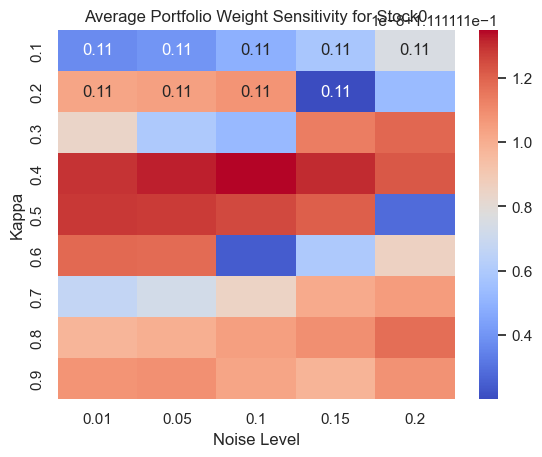

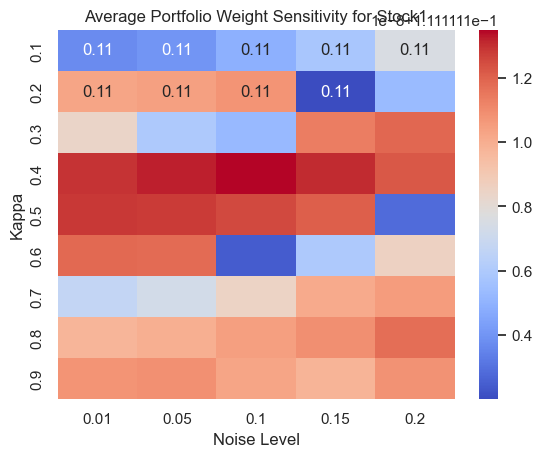

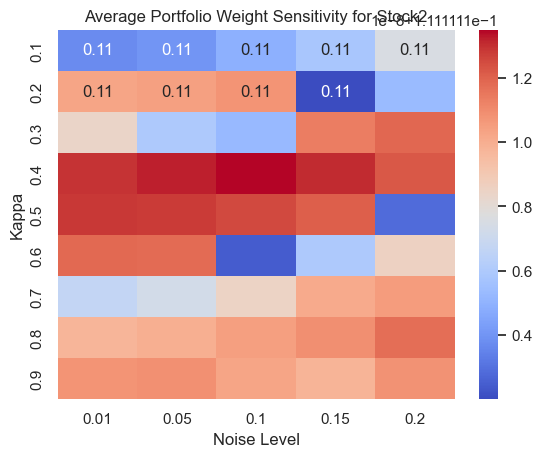

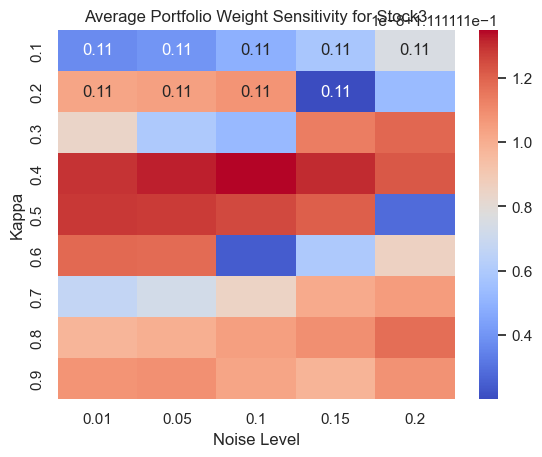

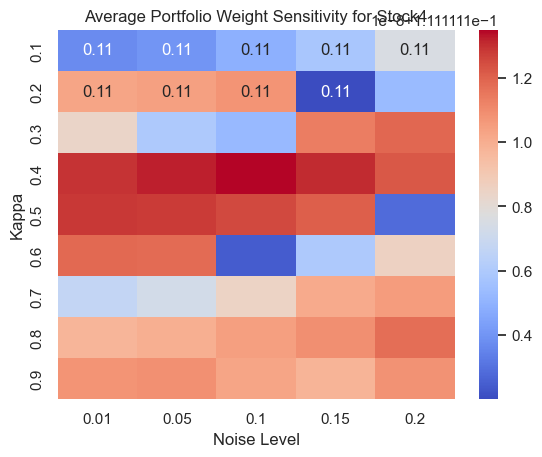

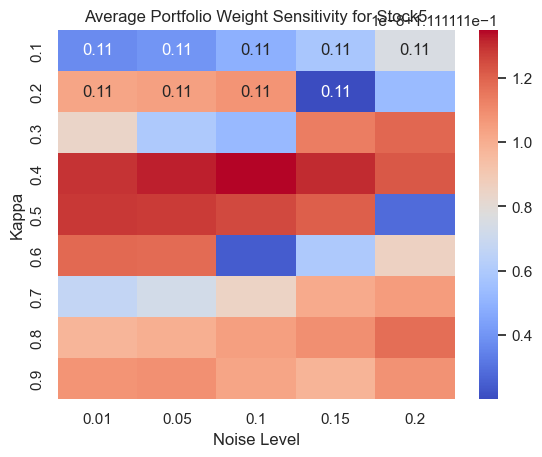

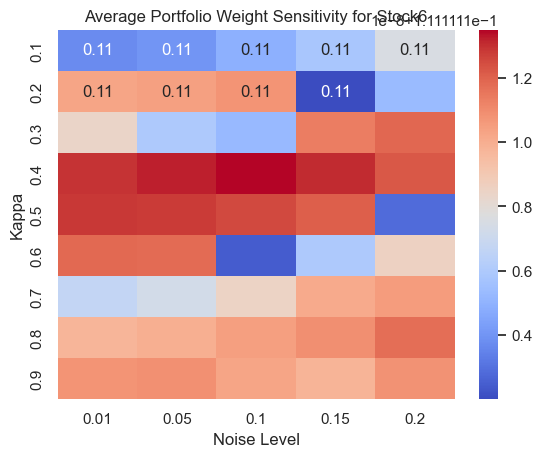

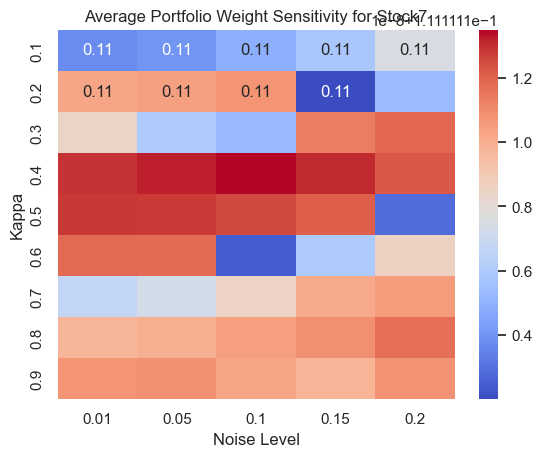

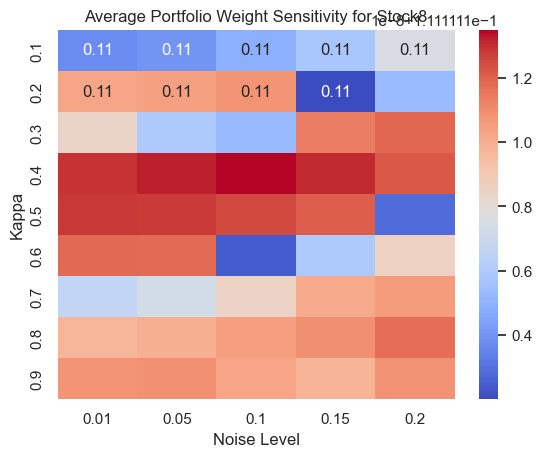

In [200]:
import seaborn as sns

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results)

# Function to extract and prepare the data for the heatmap
def prepare_heatmap_data(results_df, stock_index):
    # Extract portfolio weights for each combination of kappa and noise level
    data = []
    for _, row in results_df.iterrows():
        for idx, weight in enumerate(row['portfolio_weights']):
            data.append([row['kappa'], row['noise_level'], f'Stock{idx}', weight])
    
    # Convert to DataFrame
    weights_df = pd.DataFrame(data, columns=['kappa', 'noise_level', 'stock', 'weight'])
    
    # Pivot the DataFrame
    heatmap_data = weights_df.pivot_table(index='kappa', columns='noise_level', values='weight', aggfunc='mean').reset_index()
    
    return heatmap_data

# Plot the heatmap for each stock
for i in range(N):
    heatmap_data = prepare_heatmap_data(results_df, i)
    sns.heatmap(heatmap_data.set_index('kappa'), annot=True, cmap="coolwarm")
    plt.title(f'Average Portfolio Weight Sensitivity for Stock{i}')
    plt.ylabel('Kappa')
    plt.xlabel('Noise Level')
    plt.show()